In [102]:
import os
import time

import nbimporter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

from data_processing import load_dataset, get_samples_by_label, combine_datasets, calculate_label_distribution, display_label_distribution, display_unique_labels, display_dataset_length

from data_visualize import visualize_labels, visualize_nulls

In [104]:
files_relative_path = 'data2/'
files_names = ['LDAP.csv', 'MSSQL.csv', 'NetBIOS.csv', 'Portmap.csv', 'Syn.csv', 'UDP.csv', 'UDPLag.csv']

In [52]:
combined_df = combine_datasets(files_relative_path, files_names, nrows=100000)

In [106]:
combined_df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,13605,172.16.0.5-192.168.50.4-870-2908-17,172.16.0.5,870,192.168.50.4,2908,17,2018-11-03 10:09:00.565557,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
1,62631,172.16.0.5-192.168.50.4-871-53796-17,172.16.0.5,871,192.168.50.4,53796,17,2018-11-03 10:09:00.565559,48,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
2,143869,172.16.0.5-192.168.50.4-648-40660-17,172.16.0.5,648,192.168.50.4,40660,17,2018-11-03 10:09:00.565608,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
3,16171,172.16.0.5-192.168.50.4-872-54308-17,172.16.0.5,872,192.168.50.4,54308,17,2018-11-03 10:09:00.565993,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS
4,80845,172.16.0.5-192.168.50.4-873-40653-17,172.16.0.5,873,192.168.50.4,40653,17,2018-11-03 10:09:00.565994,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NetBIOS


In [107]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   700000 non-null  int64  
 1   Flow ID                      700000 non-null  object 
 2   Source IP                    700000 non-null  object 
 3   Source Port                  700000 non-null  int64  
 4   Destination IP               700000 non-null  object 
 5   Destination Port             700000 non-null  int64  
 6   Protocol                     700000 non-null  int64  
 7   Timestamp                    700000 non-null  object 
 8   Flow Duration                700000 non-null  int64  
 9   Total Fwd Packets            700000 non-null  int64  
 10  Total Backward Packets       700000 non-null  int64  
 11  Total Length of Fwd Packets  700000 non-null  float64
 12  Total Length of Bwd Packets  700000 non-null  float64
 13 

In [54]:
display_unique_labels(combined_df)
display_dataset_length(combined_df)

Unique Labels: ['NetBIOS' 'BENIGN' 'LDAP' 'MSSQL' 'Portmap' 'Syn' 'UDP']
Dataset length: 700000


In [108]:
label_distribution = calculate_label_distribution(combined_df, 'Label')

display_label_distribution(label_distribution)

Samples Count: NetBIOS: 199899
Percentage distribution of data: NetBIOS: 28.56%
Samples Count: UDP: 173865
Percentage distribution of data: UDP: 24.84%
Samples Count: MSSQL: 114054
Percentage distribution of data: MSSQL: 16.29%
Samples Count: Syn: 99978
Percentage distribution of data: Syn: 14.28%
Samples Count: Portmap: 95273
Percentage distribution of data: Portmap: 13.61%
Samples Count: LDAP: 9931
Percentage distribution of data: LDAP: 1.42%
Samples Count: BENIGN: 7000
Percentage distribution of data: BENIGN: 1.00%


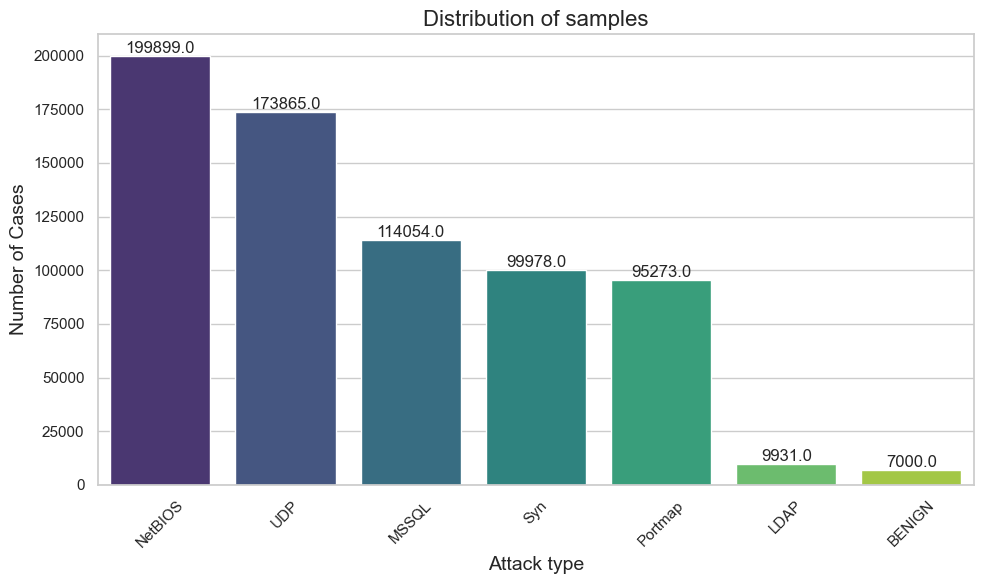

In [9]:
visualize_labels(combined_df)

Drops and Renames
Some columns are not intended for use because they are metadata. Flow ID, IP addresses, timestamps, etc.

If you are unsure why source and destination port are also removed you can read Establishing the Contaminating Effect of Metadata Feature Inclusion in Machine-Learned Network Intrusion Detection Models.. In short: any included metadata feature will act as a (very) powerful shortcut predictor.

Metadata features
Metadata features are information that is not directly related to the problem being analyzed, but may contain relevant contextual data. In the case of DDoS attack detection, such features may include:
Flow ID: a unique identifier for each network flow.
IP addresses: source and destination IP addresses can be used to identify attackers or victims.
Timestamps: timestamps can help identify when an attack took place.
Contamination of the model
Incorporating these features into a model can lead to what is known as model contamination, meaning that the model can learn to rely on these easy-to-predict features instead of the more complex patterns associated with DDoS attacks.

For example:
The model may learn that certain IP addresses are always associated with attacks, which can lead to erroneous conclusions for new, unfamiliar addresses.
Conclusion
The author suggests that removing such metadata features from training data can improve the quality of the model. This will force the model to focus on more relevant features related to attacks, which should improve its ability to generalize and be effective in detecting real attacks.
Agree with the hint
I agree with this approach. In the context of DDoS attack detection:
Complexity of the problem: Models should be trained on features that actually reflect the behavior of attacks, rather than on simple metadata indicators.
Generalization: Removing metadata features helps create models that better rad

# Data Preprocessing

In [109]:
drop_columns = [
    "Flow ID",  
    'Fwd Header Length.1',
    "Source IP", "Src IP",
    "Source Port", "Src Port",
    "Destination IP", "Dst IP",
    "Destination Port", "Dst Port",
    "Timestamp",
    "Unnamed: 0", "Inbound", "SimillarHTTP"
]

combined_df = combined_df.drop(columns=drop_columns, errors='ignore', axis=1)

# Verify removal columns
len(combined_df.columns)

78

In [110]:
def check_missing_values(data_frame):
    missing_values = data_frame.isnull().sum()
    missing_columns = missing_values[missing_values > 0]

    total_rows = data_frame.shape[0]
    
    if not missing_columns.empty:
        print("=== Kolumny z brakującymi wartościami ===")
        for column, count in missing_columns.items():
            percentage = (count / total_rows) * 100
            print(f"Kolumna: {column} - {count} brakujących wartości - ({percentage:.2f}% danych)")
    else:
        print("Brak brakujących wartości w zbiorze danych.")

In [111]:
check_missing_values(combined_df)

=== Kolumny z brakującymi wartościami ===
Kolumna: Flow Bytes/s - 8 brakujących wartości - (0.00% danych)


Dropping duplicates
There should be no duplicates because they can bias training and can lead
to over-optimistic estimates of classification performance during testing.

In [112]:
def delete_duplicates(data):
    print(data.duplicated().sum(), "fully duplicate rows to remove")   
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)  
    print(data.shape)
    return data

combined_df = delete_duplicates(combined_df)

display_dataset_length(combined_df)

547445 fully duplicate rows to remove
(152555, 78)
Dataset length: 152555


In [113]:
def imputation_missing_number_values(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    columns_imputed = 0
    columns_dropped = 0

    columns_to_drop = []
    
    for column in df.select_dtypes(include=[np.number]).columns:
        missing_percentage = df[column].isnull().mean() * 100
        
        if missing_percentage > 0:
            if missing_percentage <= 20:
                median_value = df[column].median()
                df[column] = df[column].fillna(median_value)
                columns_imputed += 1
            else:
                columns_to_drop.append(column)
                columns_dropped += 1

    df.drop(columns=columns_to_drop, inplace=True)

    print(f"Imputation median in {columns_imputed} columns.")
    print(f"Deleted {columns_dropped} columns")

    return df

In [114]:
combined_df = imputation_missing_number_values(combined_df)

Imputation median in 2 columns.
Deleted 0 columns


In [118]:
combined_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
1,17,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
3,17,1,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS
4,17,2,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NetBIOS


In [120]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152555 entries, 0 to 152554
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Protocol                     152555 non-null  int64  
 1   Flow Duration                152555 non-null  int64  
 2   Total Fwd Packets            152555 non-null  int64  
 3   Total Backward Packets       152555 non-null  int64  
 4   Total Length of Fwd Packets  152555 non-null  float64
 5   Total Length of Bwd Packets  152555 non-null  float64
 6   Fwd Packet Length Max        152555 non-null  float64
 7   Fwd Packet Length Min        152555 non-null  float64
 8   Fwd Packet Length Mean       152555 non-null  float64
 9   Fwd Packet Length Std        152555 non-null  float64
 10  Bwd Packet Length Max        152555 non-null  float64
 11  Bwd Packet Length Min        152555 non-null  float64
 12  Bwd Packet Length Mean       152555 non-null  float64
 13 

In [115]:
label_distribution = calculate_label_distribution(combined_df, 'Label')
display_label_distribution(label_distribution)

Samples Count: UDP: 85038
Percentage distribution of data: UDP: 55.74%
Samples Count: Syn: 38071
Percentage distribution of data: Syn: 24.96%
Samples Count: MSSQL: 19638
Percentage distribution of data: MSSQL: 12.87%
Samples Count: BENIGN: 6498
Percentage distribution of data: BENIGN: 4.26%
Samples Count: NetBIOS: 1454
Percentage distribution of data: NetBIOS: 0.95%
Samples Count: Portmap: 1276
Percentage distribution of data: Portmap: 0.84%
Samples Count: LDAP: 580
Percentage distribution of data: LDAP: 0.38%


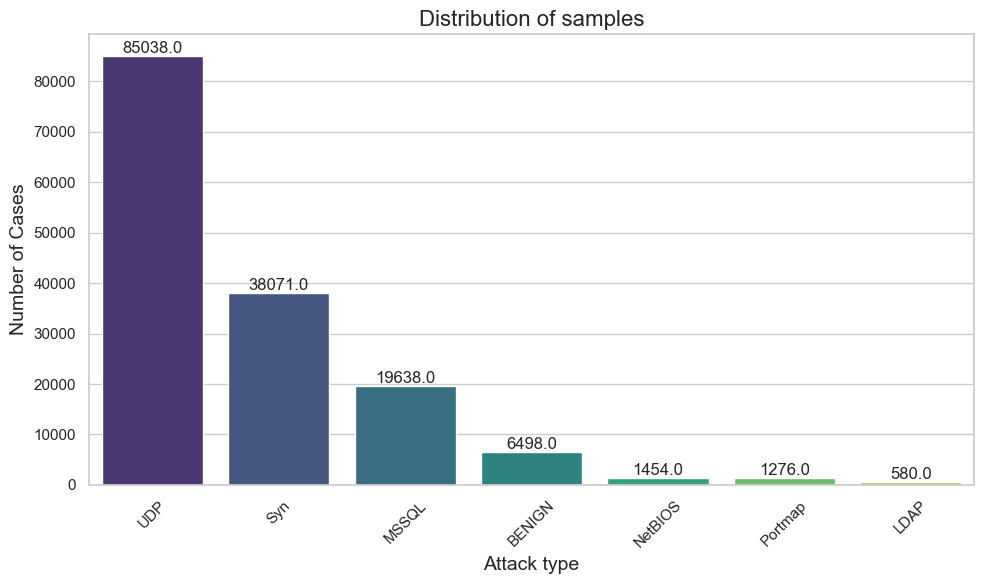

In [123]:
 visualize_labels(combined_df)

In [134]:
def map_label(df):
    # Mapping labels to numerical values
    label_mapping = {
        "BENIGN": 0,
        "NetBIOS": 1,
        "LDAP": 2,
        "MSSQL": 3,
        "Portmap": 4,
        "Syn": 5,
        "UDP": 6
    }
    df['Label'] = df['Label'].map(label_mapping)
    # df['Label'] = df['Label'].astype('category')
    
    return df

In [135]:
mapped_df = map_label(combined_df.copy())
print(mapped_df['Label'].unique())

[1 0 2 3 4 5 6]


In [136]:
mapped_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,17,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,17,1,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,17,2,2,0,494.0,0.0,247.0,247.0,247.0,0.0,...,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [137]:
label_distribution = calculate_label_distribution(mapped_df, 'Label')
display_label_distribution(label_distribution)

Samples Count: 6: 85038
Percentage distribution of data: 6: 55.74%
Samples Count: 5: 38071
Percentage distribution of data: 5: 24.96%
Samples Count: 3: 19638
Percentage distribution of data: 3: 12.87%
Samples Count: 0: 6498
Percentage distribution of data: 0: 4.26%
Samples Count: 1: 1454
Percentage distribution of data: 1: 0.95%
Samples Count: 4: 1276
Percentage distribution of data: 4: 0.84%
Samples Count: 2: 580
Percentage distribution of data: 2: 0.38%


# Visualization Data

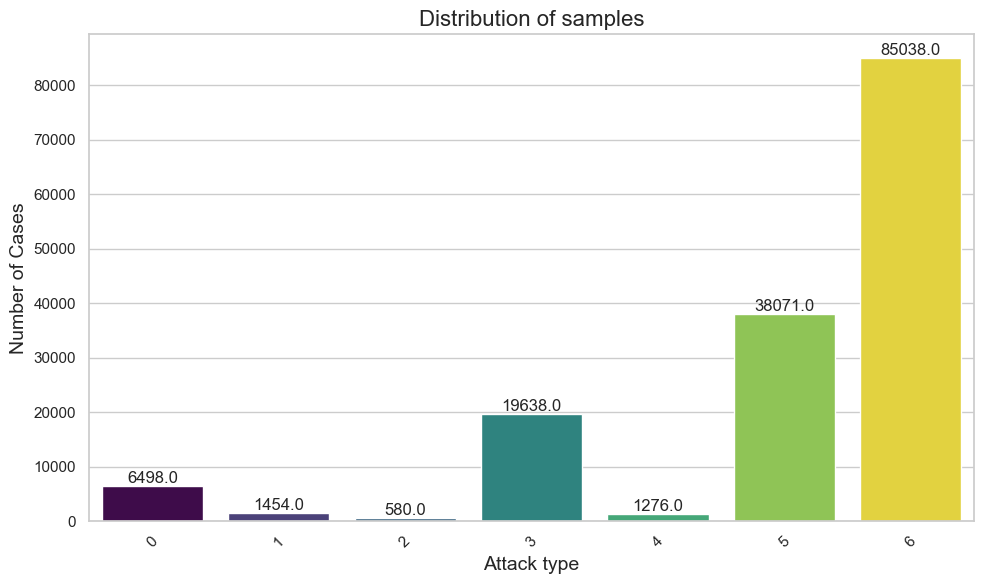

In [138]:
visualize_labels(mapped_df)

# Data splitting into training and test

In [142]:
## Feature and Target variable
X = mapped_df.drop('Label', axis=1)
y = mapped_df['Label']

## Always check dataset length
assert len(X) == len(y), "The lengths of feature sets and labels do not match."

In [143]:
## Split data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [144]:
def generate_smoth_samples(X_train, Y_train):
        # Initalize SMOTE
        smote = SMOTE(random_state=42)
    
        # Generate new samples
        X_resampled, y_resampled = smote.fit_resample(X_train, Y_train)
    
        # Check the distribution of classes after applying SMOTE
        print("Class distribution after application of SMOTE:")
        print(pd.Series(y_resampled).value_counts())

        return X_resampled, y_resampled
    
X_resampled, y_resampled = generate_smoth_samples(X_train, Y_train)

Class distribution after application of SMOTE:
Label
6    67977
5    67977
0    67977
3    67977
4    67977
1    67977
2    67977
Name: count, dtype: int64


In [145]:
def time_execution(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"time execution: {execution_time:.4f} minut")
    
    return result

# Training Model

## Random Forest


Algorytmy do rozważenia
Oprócz Random Forest, istnieje wiele innych algorytmów, które są znane jako dobre klasyfikatory wieloklasowe:

- Gradient Boosting Machines (GBM): Algorytmy takie jak XGBoost, LightGBM czy CatBoost są bardzo popularne w zadaniach klasyfikacyjnych i często osiągają lepsze wyniki niż tradycyjne metody.
  
- Support Vector Machines (SVM): SVM mogą być używane z różnymi jądrami do klasyfikacji wieloklasowej.

- K-nearest neighbors (KNN): Prosty, ale skuteczny algorytm, który działa dobrze w przypadku małych zbiorów danych.
  
- Neural Networks: Sieci neuronowe, zwłaszcza w kontekście głębokiego uczenia, mogą być bardzo skuteczne w klasyfikacji wieloklasowej.
  
- Naive Bayes: Dobry wybór dla problemów z dużą liczbą cech, zwłaszcza gdy dane są rozkładane normalnie.

In [146]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
time_execution(rf_model.fit, X_resampled, y_resampled)
rf_pred = rf_model.predict(X_test)
rf_pred

time execution: 0.4927 minut


array([6, 6, 3, ..., 6, 6, 5])

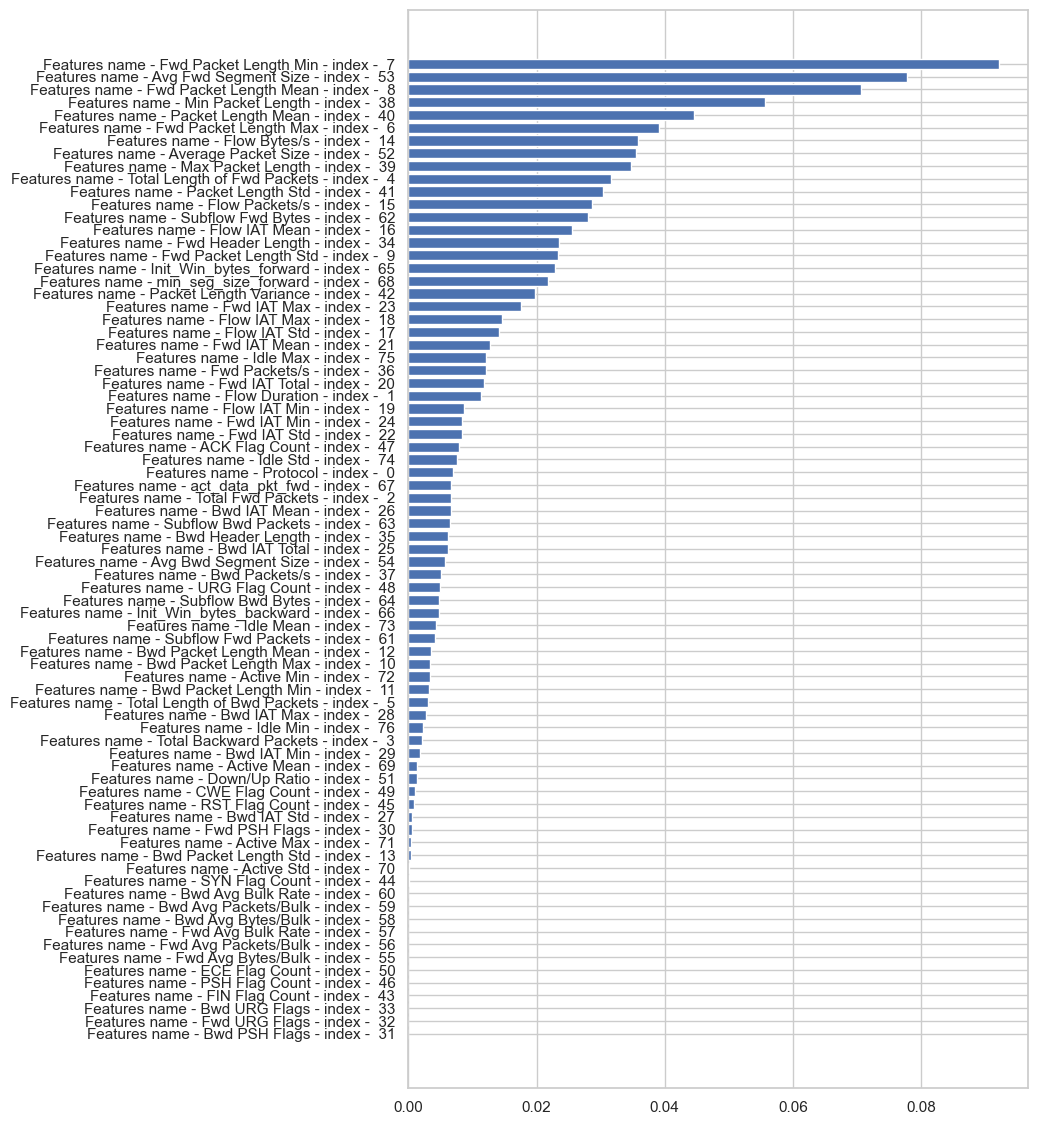

In [148]:
## importances feature from the model
def show_importances_feature(model):
    importances = model.feature_importances_

    ## sorted by importance
    indexes = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
    feature_column_names = [f"Features name - {mapped_df.columns[i]} - index -  {i}" for i in indexes]
    
    plt.figure(figsize=(8, 14))
    plt.barh(range(X_train.shape[1]), importances[indexes], align="center")
    plt.yticks(range(X_train.shape[1]), feature_column_names)
    plt.show()

show_importances_feature(rf_model)

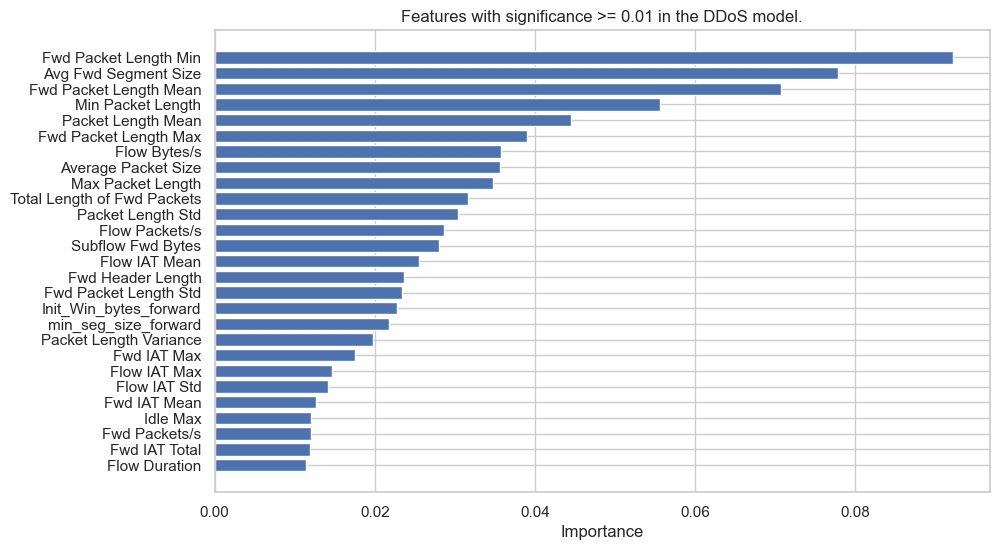

In [149]:
def extract_important_features(model, mapped_df, threshold=0.010):
    # Importances feature from the model
    importances = model.feature_importances_
    
    # Get the indices of features that meet the threshold
    indices = np.where(importances >= threshold)[0]  # Get indices of features with importance >= threshold
    
    # If no features meet the threshold, return a message
    if len(indices) == 0:
        print("No features with significance >= {}.".format(threshold))
        return

    # Get feature names and importances of the selected features
    important_feature_names = [mapped_df.columns[i] for i in indices]
    important_importances = importances[indices]

    # Sort features by importance in descending order
    sorted_indices = np.argsort(important_importances)
    sorted_feature_names = [important_feature_names[i] for i in sorted_indices]
    sorted_importances = important_importances[sorted_indices]
    
    # Create a horizontal bar plot for the important features
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_feature_names, sorted_importances, align='center')
    plt.xlabel('Importance')
    plt.title('Features with significance >= {} in the DDoS model.'.format(threshold))
    plt.show()

    return indices

# Wywołanie funkcji z modelem rf_model
important_features_indices = extract_important_features(rf_model, mapped_df)

Wybór istotnych cech w modelu DDoS
Aby określić, które cechy są istotne dla modelu detekcji ataków DDoS, warto przyjąć pewien próg dla wartości ważności cech. W przypadku modeli opartych na drzewach decyzyjnych, takich jak Random Forest, można wykorzystać wartości ważności cech (feature importances) do oceny ich wpływu na model.

- Próg 0.05 (5%):
Cechy o ważności powyżej 5% są zazwyczaj uznawane za istotne. Ten próg jest często stosowany w praktyce i może pomóc w redukcji liczby cech do tych, które mają bardziej znaczący wpływ na wyniki modelu.

- Próg 0.1 (10%):
Cechy o ważności powyżej 10% są zdecydowanie istotne i powinny być brane pod uwagę w kolejnych iteracjach modelowania. Umożliwia to skoncentrowanie się na tych cechach, które mają największy wpływ na wydajność modelu.


- Próg 0.2 (20%):
Cechy o ważności powyżej 20% mogą być uznawane za kluczowe dla modelu. Wybór tylko tych cech może prowadzić do uproszczenia modelu i poprawy interpretowalności

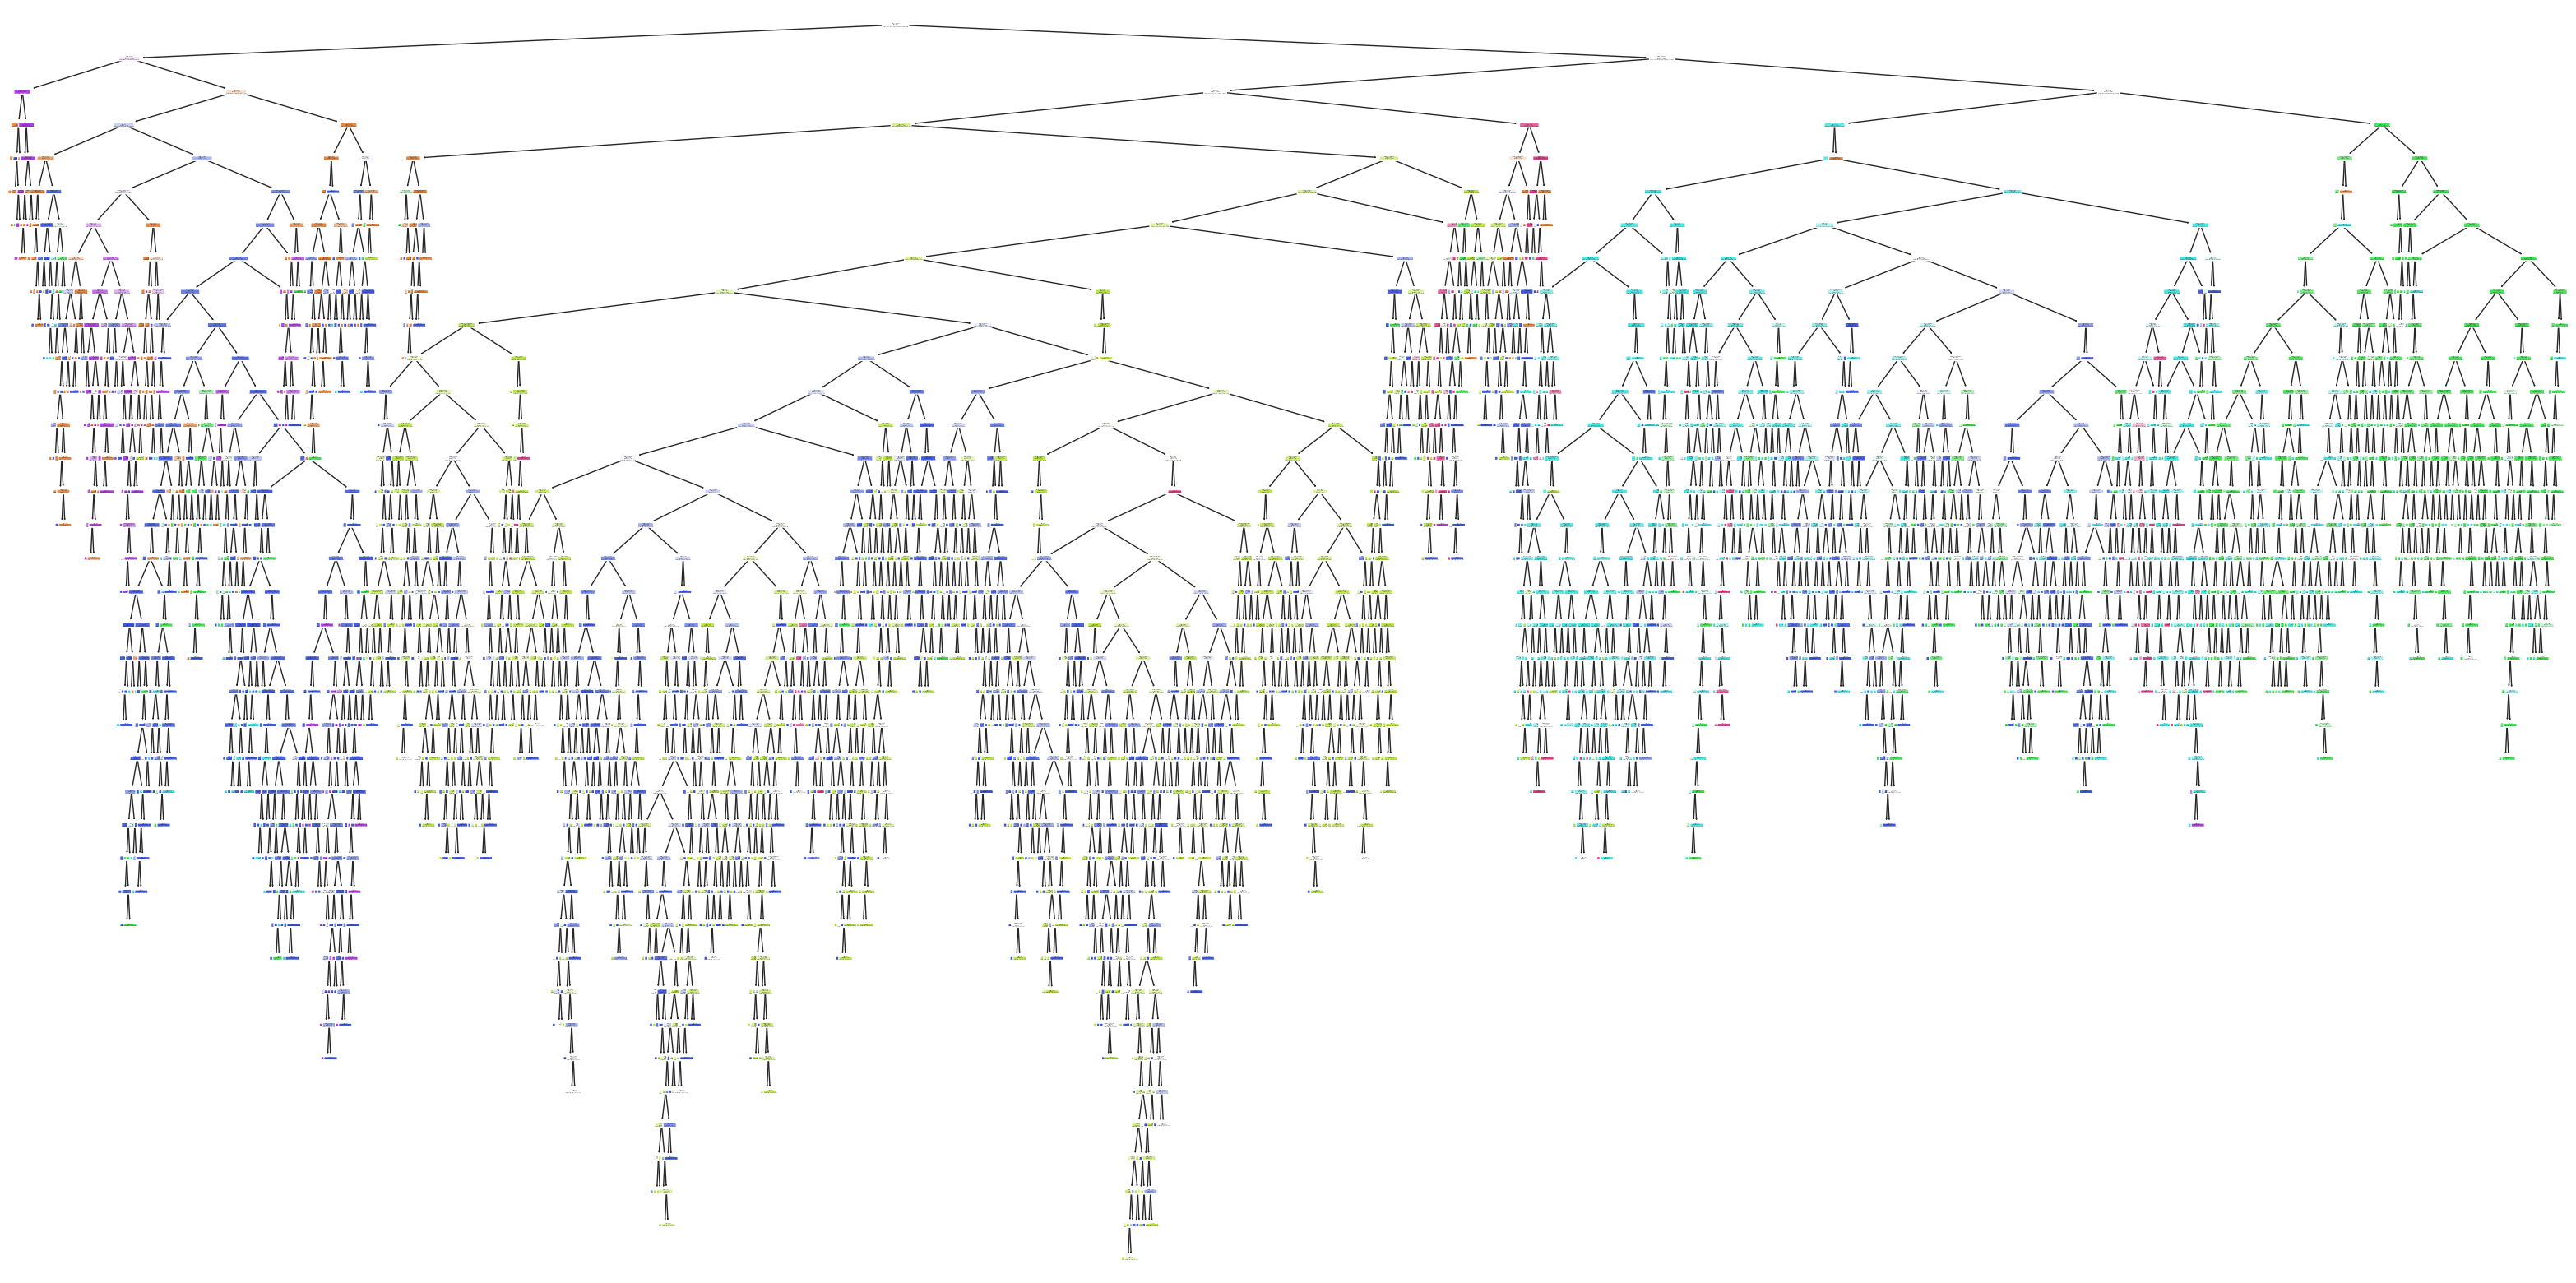

In [79]:
from sklearn.tree import plot_tree

estimator = rf_model.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, rounded=True)

plt.show()

# Model Evaluation

In [86]:
 ## Generate and display a detailed confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=classes, yticklabels=classes)
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [153]:
def visualizationMetrics(accuracy, f1, precision, recall):
   metrics_data = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Value': [accuracy, f1, precision, recall]
    }

   df_metrics = pd.DataFrame(metrics_data)

   print(df_metrics)

In [152]:
rf_accuracy = accuracy_score(Y_test, rf_pred)

# Użycie 'macro' jako przykład
rf_f1 = f1_score(Y_test, rf_pred, average='macro')
rf_precision = precision_score(Y_test, rf_pred, average='macro')
rf_recall = recall_score(Y_test, rf_pred, average='macro')

visualizationMetrics(rf_accuracy, rf_f1, rf_precision, rf_recall)

      Metric     Value
0   Accuracy  0.978270
1   F1 Score  0.814904
2  Precision  0.802173
3     Recall  0.831075


### Visualization

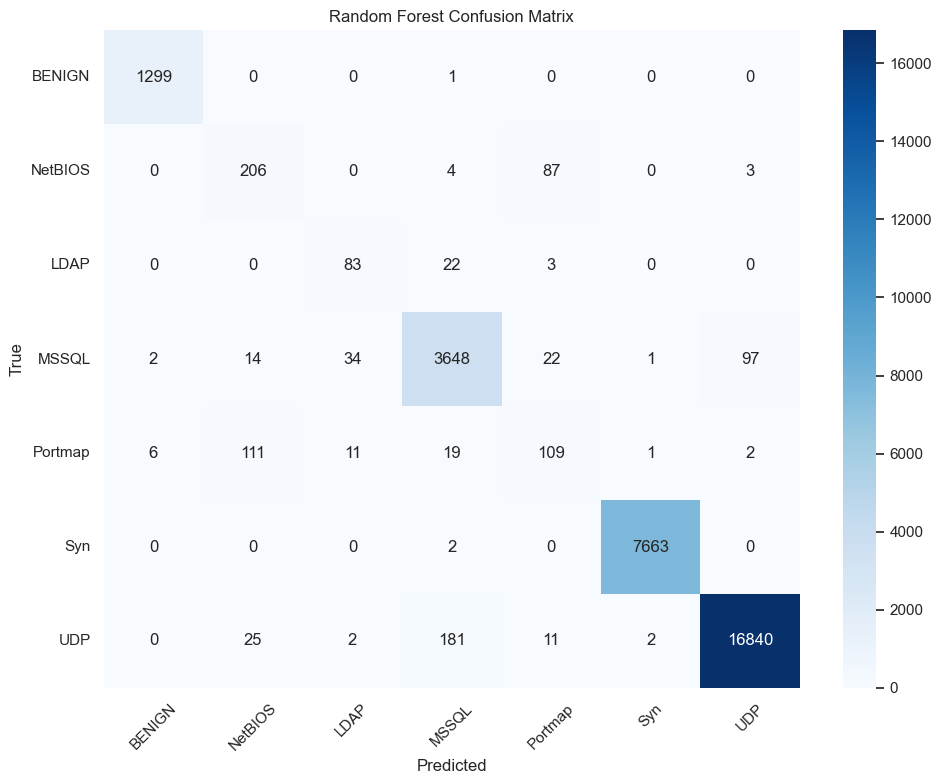

In [94]:
classes = ['BENIGN', 'NetBIOS', 'LDAP', 'MSSQL', 'Portmap', 'Syn', 'UDP']

plot_confusion_matrix(Y_test, rf_pred, classes, "Random Forest Confusion Matrix")

### SVC - Support Vector Machine

In [59]:
svm_model = SVC(kernel='rbf', random_state=42)
time_execution(svm_model.fit, X_resampled, y_resampled)
y_pred = svm_model.predict(X_test)
y_pred

time execution: 26.0877 minut


array([6, 6, 6, ..., 5, 6, 6])

In [95]:
svm_accuracy = accuracy_score(Y_test, y_pred)

# Użycie 'macro' jako przykład
svm_f1 = f1_score(Y_test, y_pred, average='macro')
svm_precision = precision_score(Y_test, y_pred, average='macro')
svm_recall = recall_score(Y_test, y_pred, average='macro')

visualizationMetrics(svm_accuracy, svm_f1, svm_precision, svm_recall)

NameError: name 'y_pred' is not defined

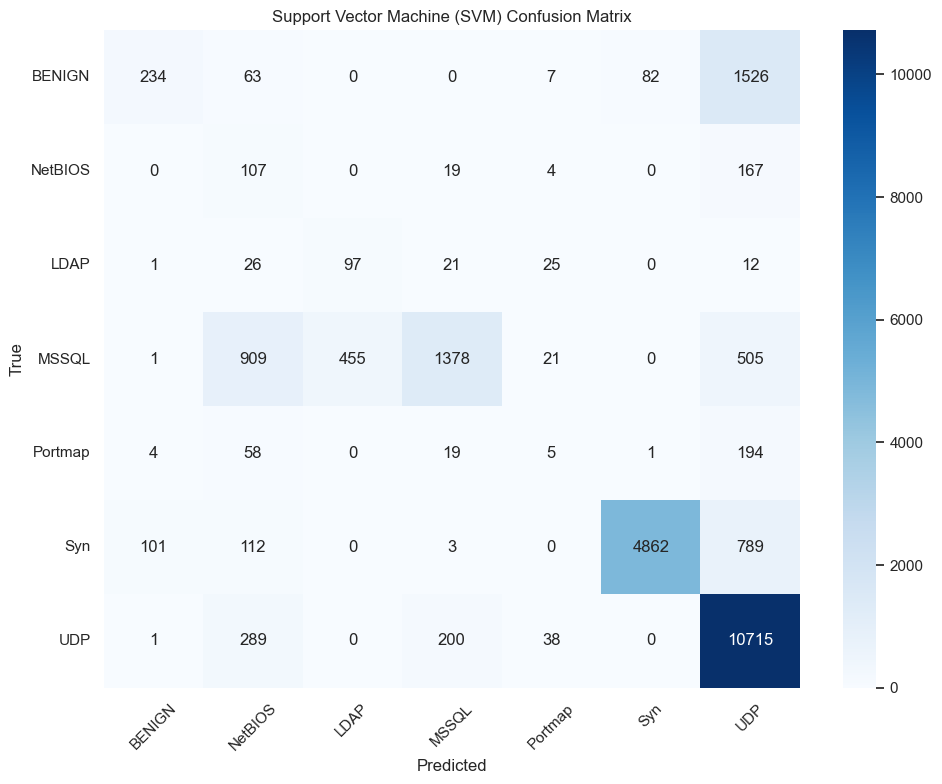

In [92]:
plot_confusion_matrix(Y_test, y_pred, classes, "Support Vector Machine (SVM) Confusion Matrix")

### Neural Network

In [92]:
nn_model = MLPClassifier(hidden_layer_sizes=(300,), max_iter=300, random_state=42)

time_execution(nn_model.fit, X_train, Y_train)
nn_pred = nn_model.predict(X_test)

time execution: 0.8064 minut


In [96]:
nn_accuracy = accuracy_score(Y_test, nn_pred)
nn_f1 = f1_score(Y_test, nn_pred, average='macro')
nn_precision = precision_score(Y_test, nn_pred, average='macro')
nn_recall = recall_score(Y_test, nn_pred, average='macro')


print(f"Accuracy: {nn_accuracy:.4f}")
print(f"F1 Score: {nn_f1:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"Recall: {nn_recall:.4f}")

Accuracy: 0.6295
F1 Score: 0.3197
Precision: 0.6757
Recall: 0.3005


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


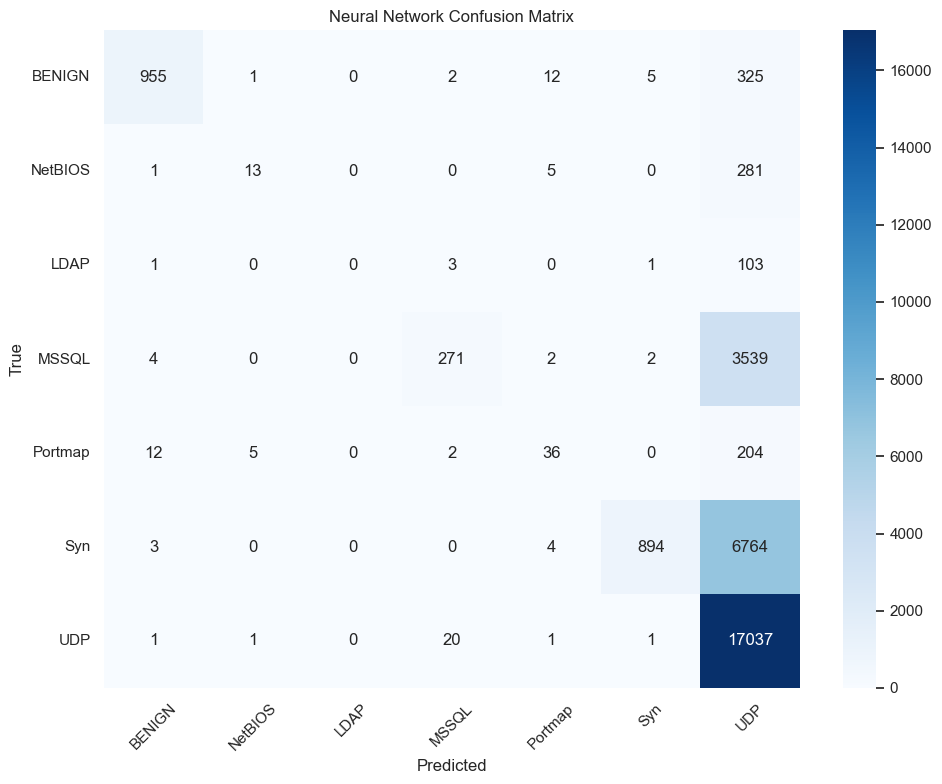

In [97]:
plot_confusion_matrix(Y_test, nn_pred, classes, "Neural Network Confusion Matrix")

# KNN

In [98]:
knn_model = KNeighborsClassifier(n_neighbors=4)

time_execution(knn_model.fit, X_train, Y_train)

knn_pred = knn_model.predict(X_test)

time execution: 0.0009 minut


In [99]:
knn_accuracy = accuracy_score(Y_test, knn_pred)
knn_f1 = f1_score(Y_test, knn_pred, average='macro')
knn_precision = precision_score(Y_test, knn_pred, average='macro')
knn_recall = recall_score(Y_test, knn_pred, average='macro')

print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"KNN F1 Score: {knn_f1:.4f}")
print(f"KNN Precision: {knn_precision:.4f}")
print(f"KNN Recall: {knn_recall:.4f}")

KNN Accuracy: 0.9685
KNN F1 Score: 0.7657
KNN Precision: 0.7767
KNN Recall: 0.7646


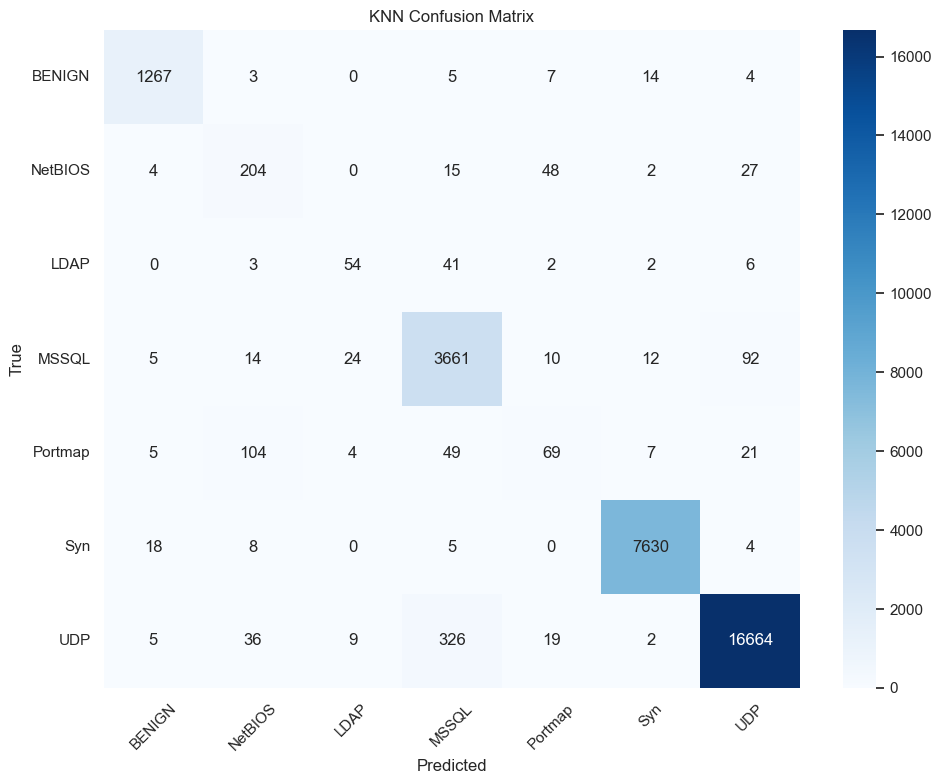

In [100]:
plot_confusion_matrix(Y_test, knn_pred, classes, "KNN Confusion Matrix")

KNN nie ma wbudowanej metody oceny istotności cech, ponieważ działa na zasadzie porównywania odległości między punktami w przestrzeni cech. Możesz jednak użyć kilku podejść, aby ocenić istotność cech:
Permutacyjna ważność cech: Możesz obliczyć dokładność modelu KNN na zbiorze testowym, a następnie permutować wartości jednej cechy i ponownie ocenić dokładność. Różnica w dokładności przed i po permutacji wskazuje na znaczenie tej cechy.

NameError: name 'feature_names' is not defined

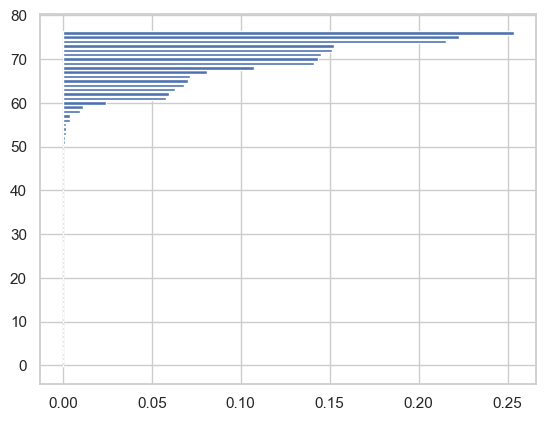

In [101]:
result = permutation_importance(knn_model, X_test, Y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance for KNN")
plt.show()

# Naive Bayes

In [ ]:
nb_model = GaussianNB()

time_execution(nb_model.fit, X_train, Y_train)

nb_pred = nb_model.predict(X_test)

In [ ]:
nb_accuracy = accuracy_score(Y_test, nb_pred)
nb_f1 = f1_score(Y_test, nb_pred, average='macro')
nb_precision = precision_score(Y_test, nb_pred, average='macro')
nb_recall = recall_score(Y_test, nb_pred, average='macro')

print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print(f"Naive Bayes F1 Score: {nb_f1:.4f}")
print(f"Naive Bayes Precision: {nb_precision:.4f}")
print(f"Naive Bayes Recall: {nb_recall:.4f}")

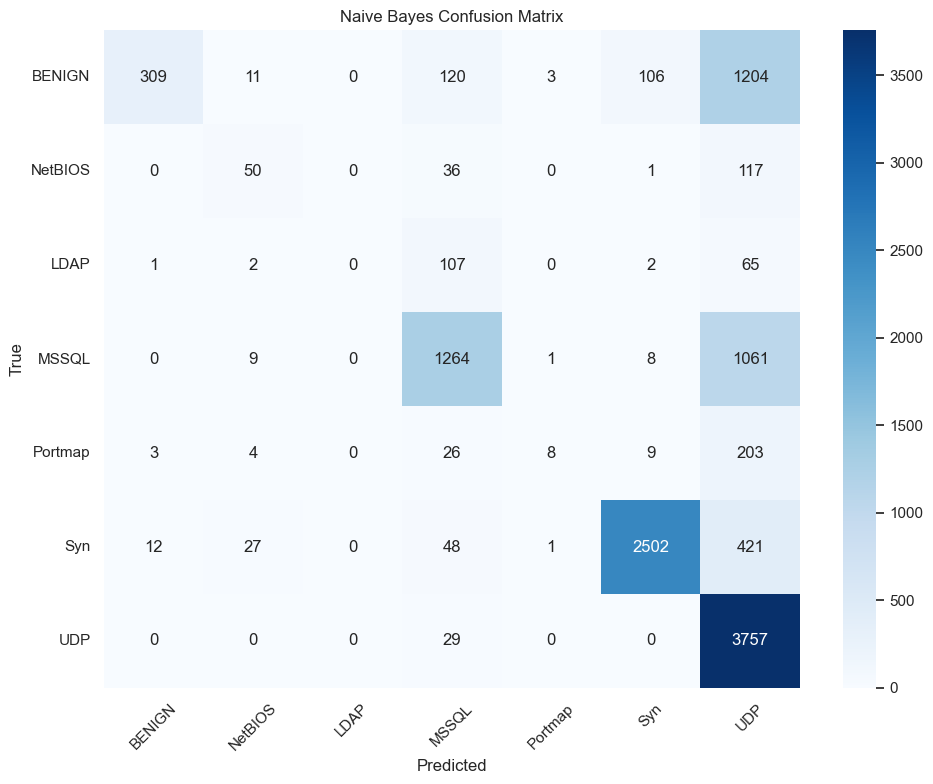

In [42]:
plot_confusion_matrix(Y_test, nb_pred, classes, "Naive Bayes Confusion Matrix")

In [74]:
# Ocena współczynników prawdopodobieństwa
class_probabilities = nb_model.predict_proba(X_test)

# Re-learning

In [77]:
def trim_datataset(mapped_df, important_features_indices):
    # Create a new DataFrame with only important features
    trimmed_df = mapped_df.iloc[:, important_features_indices].copy()  # Keep only important features
    trimmed_df['Label'] = mapped_df['Label']  # Ensure to keep the label column
    
    return trimmed_df

trimmed_dataset = trim_datataset(mapped_df, important_features_indices)
len(trimmed_dataset)

38421

In [79]:
## Feature and Target variable
re_X = trimmed_dataset.drop('Label', axis=1)
re_Y = trimmed_dataset['Label']


## Convert to numPy array
re_x1 = np.array(X).astype(np.float64)
re_y1 = np.array(Y)

## Always check dataset length
assert len(re_X) == len(re_Y), "The lengths of feature sets and labels do not match."

In [80]:
## Split data into training and testing set
re_X_train, re_X_test, re_Y_train, re_Y_test = train_test_split(re_X, re_Y, test_size=0.30, random_state=42)

## Check
re_train_persent = len(re_X_train) / len(trimmed_dataset) * 100
re_test_percent = len(re_X_test) / len(trimmed_dataset) * 100

print("Train", re_train_persent)
print("Test", re_test_percent)

Train 69.99817807969599
Test 30.001821920304


In [81]:
re_X_resampled, re_y_resampled = generate_smoth_samples(re_X_train, re_Y_train)

Class distribution after application of SMOTE:
Label
5    8816
6    8816
3    8816
0    8816
1    8816
4    8816
2    8816
Name: count, dtype: int64


In [82]:
re_rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
time_execution(rf_model.fit, re_X_resampled, re_y_resampled)
re_rf_pred = rf_model.predict(re_X_test)
re_rf_pred

time execution: 0.0523 minut


array([0, 5, 6, ..., 0, 5, 5])

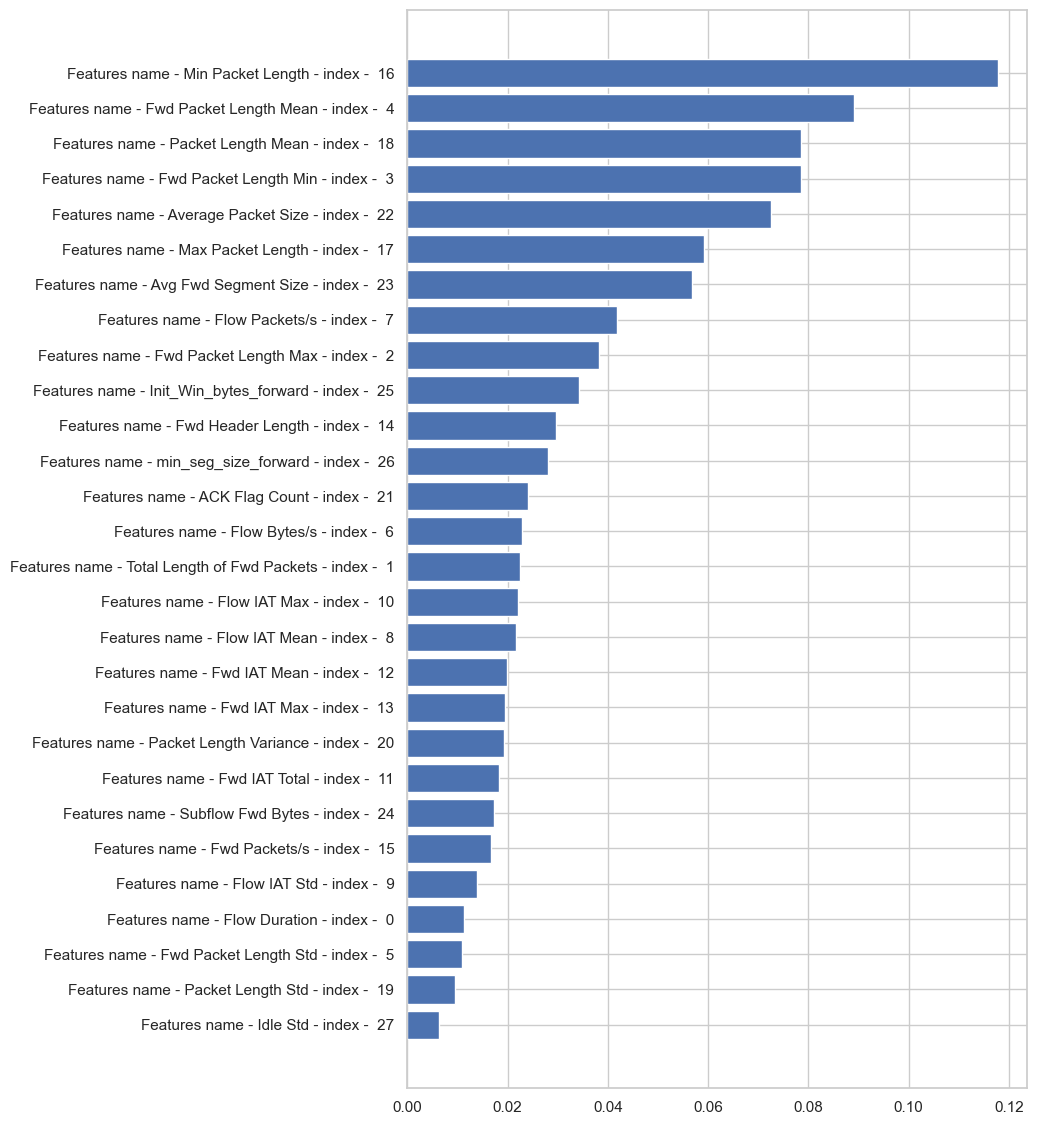

In [83]:
importances = rf_model.feature_importances_

indexes = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
feature_column_names = [f"Features name - {trimmed_dataset.columns[i]} - index -  {i}" for i in indexes]

plt.figure(figsize=(8, 14))
plt.barh(range(re_X_train.shape[1]), importances[indexes], align="center")
plt.yticks(range(re_X_train.shape[1]), feature_column_names)
plt.show()

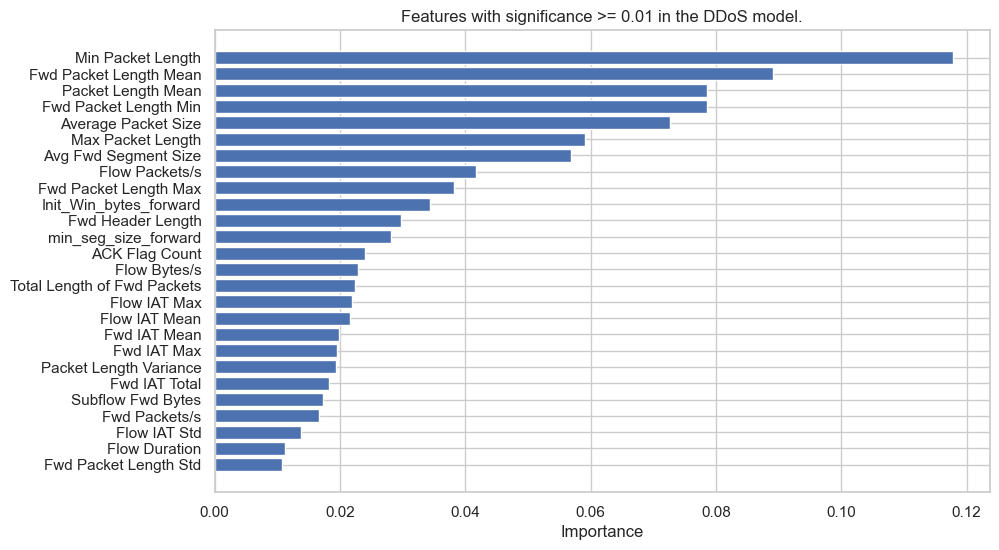

In [84]:
important_features_indices = extract_important_features(rf_model, trimmed_dataset)

In [87]:
new_rf_accuracy = accuracy_score(re_Y_test, re_rf_pred)

# Użycie 'macro' jako przykład
new_rf_f1 = f1_score(re_Y_test, re_rf_pred, average='macro')
new_rf_precision = precision_score(re_Y_test, re_rf_pred, average='macro')
new_rf_recall = recall_score(re_Y_test, re_rf_pred, average='macro')

print("------------ before trimming ------------")
visualizationMetrics(rf_accuracy, rf_f1, rf_precision, rf_recall)
print("------------ after trimming ------------")
visualizationMetrics(new_rf_accuracy, new_rf_f1, new_rf_precision, new_rf_recall)

------------ before trimming ------------
      Metric     Value
0   Accuracy  0.974842
1   F1 Score  0.879065
2  Precision  0.869852
3     Recall  0.889647
------------ after trimming ------------
      Metric     Value
0   Accuracy  0.976316
1   F1 Score  0.885285
2  Precision  0.874388
3     Recall  0.898195


Analiza Wyników
- Accuracy:
Spadek z 0.974144 do 0.974014 jest minimalny i sugeruje, że model nadal dobrze klasyfikuje dane, mimo że nieco gorzej niż wcześniej.

- F1 Score:
Wzrost z 0.848583 do 0.850568 wskazuje na lepszą równowagę między precyzją a czułością (recall). Oznacza to, że model lepiej radzi sobie z identyfikowaniem pozytywnych przypadków (DDoS), co jest kluczowe w kontekście detekcji ataków.


- Precision:
Minimalny spadek z 0.830370 do 0.830247 sugeruje, że liczba fałszywych alarmów (false positives) pozostała na podobnym poziomie, co może być korzystne w kontekście detekcji ataków, gdzie fałszywe alarmy mogą prowadzić do niepotrzebnych działań.


- Recall:
Wzrost z 0.870465 do 0.875301 oznacza, że model lepiej identyfikuje rzeczywiste ataki DDoS, co jest kluczowe dla skuteczności systemu detekcji.

### Model Comparison

In [48]:
rf_proba = rf_model.predict_proba(X_test)

nn_proba = nn_model.predict_proba(X_test)

# svm_proba = svm_model.predict_proba(X_test)

kn_proba = knn_model.predict_proba(X_test)

nb_proba = nb_model.predict_proba(X_test)

 Użycie Krzywej ROC dla Klasyfikacji Wieloklasowej
Dla klasyfikacji wieloklasowej można zastosować jedną z dwóch popularnych metod:

- One-vs-Rest (OvR): Dla każdej klasy tworzony jest osobny model binarny, który odróżnia tę klasę od wszystkich pozostałych. Następnie obliczane są krzywe ROC dla każdego modelu.

- One-vs-One (OvO): Tworzenie modelu dla każdej pary klas. To podejście jest bardziej złożone i może być mniej wydajne w przypadku dużej liczby klas.

### Implementation of the ROC Curve with the One-vs-Rest Method

In [89]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, Y_test):

    # Binarizacja etykiet
    n_classes = len(np.unique(Y_test))
    Y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))
    
    proba = model.predict_proba(X_test)

    # Obliczanie krzywych ROC i AUC dla każdej klasy
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Rysowanie krzywych ROC
    plt.figure(figsize=(10, 8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Classifier (AUC - 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class Classification')
    plt.legend()
    plt.grid()
    plt.show()

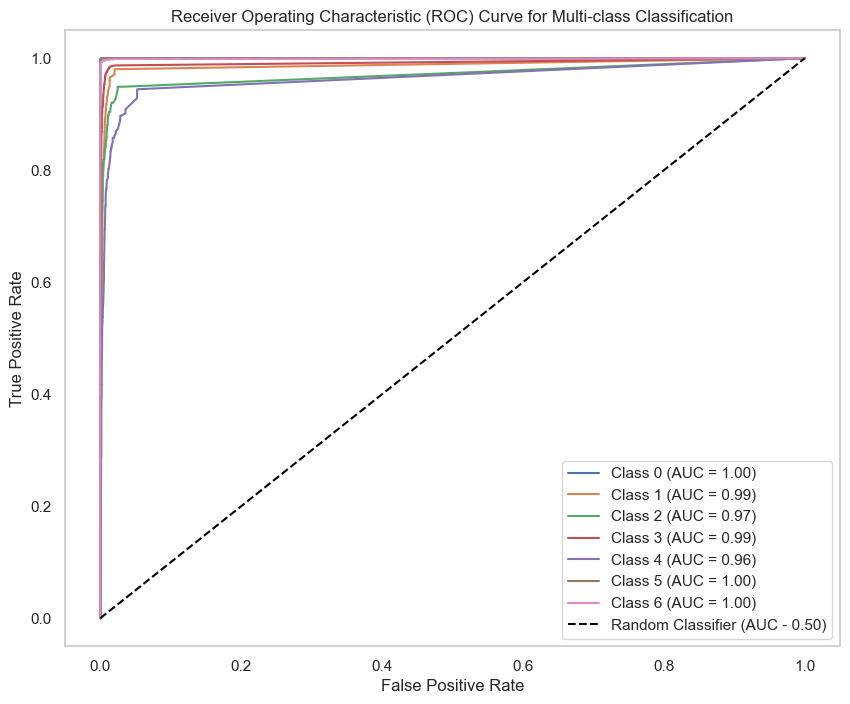

In [92]:
plot_roc_curve(rf_model, re_X_test, re_Y_test)

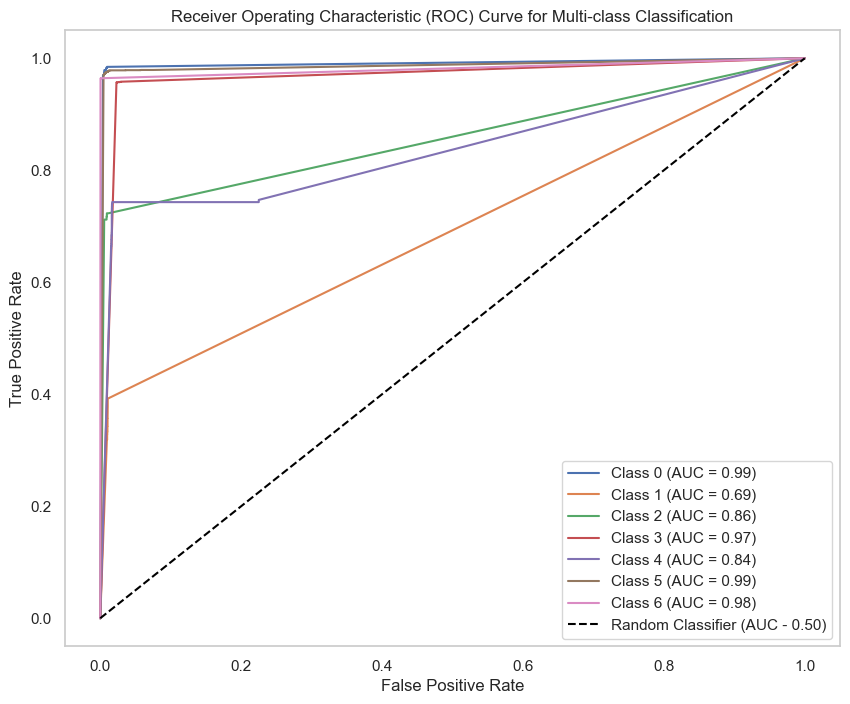

In [69]:
plot_roc_curve(nn_model, X_test, Y_test)

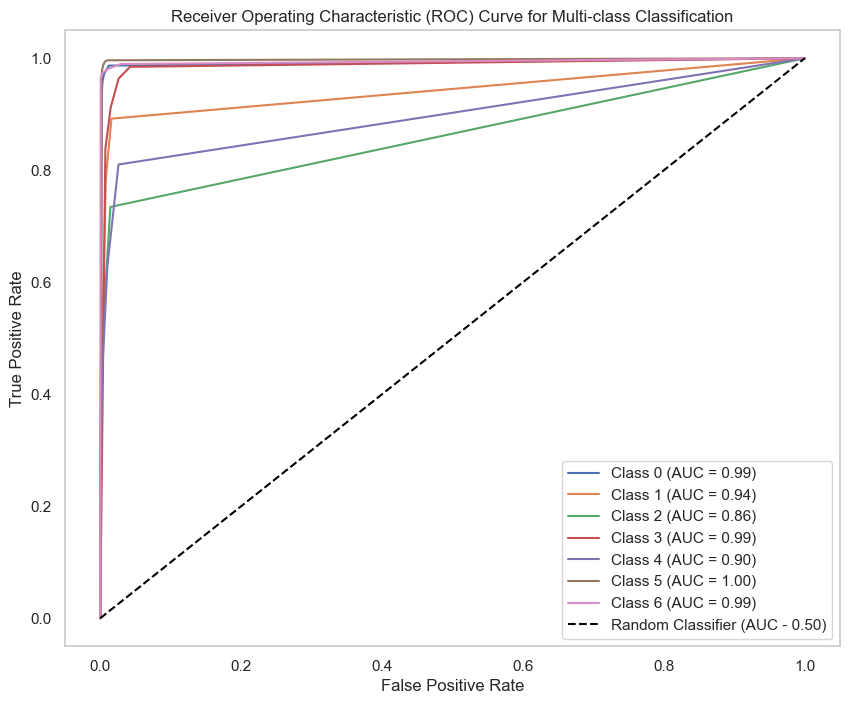

In [68]:
plot_roc_curve(knn_model, X_test, Y_test)

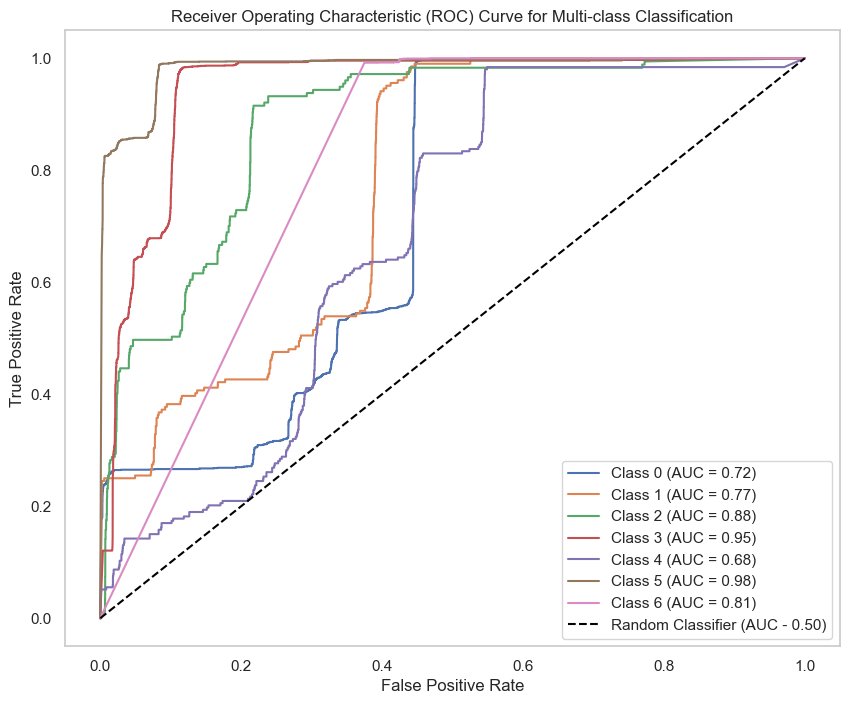

In [93]:
plot_roc_curve(nb_model, X_test, Y_test)